In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [14]:
import pickle
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/MLHC_project" "/content/MLHC_project"

#Load Data

In [ ]:
data= pd.read_csv("MLHC_project/data_processed.csv",index_col=0)
data.replace({'Yes':1,'No':0},inplace=True)
data = data.reset_index().rename(columns={'index':'patient_code'})

In [ ]:
#drop a patient with categorical missing values
data = data.drop(index=1451)

In [ ]:
fixed_clinical_cols = load_obj("MLHC_project/fixed_cols_clinical.pkl")
measurement_cols = load_obj("MLHC_project/measurement_cols.pkl")

# Defining X & Y

In [ ]:
orig_groups = data['patient_code']
y = data['outcome28']
X = data.drop(columns=['day','survival28','outcome28', 'age-group', 'ID'])

In [ ]:
X = X.drop(columns='patient_code')

In [ ]:
X.shape

In [ ]:
print(f"Positive labels portion: {y.sum() / y.shape[0]:.3f}")

# Define Numeric and Categorial Features

In [ ]:
def find_categorical_columns(dataframe, threshold=0.01):
    categorical_columns = []

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or len(dataframe[column].unique()) / len(dataframe[column]) <= threshold:
            categorical_columns.append(column)

    return categorical_columns

categorical_features = find_categorical_columns(X)
numeric_features = X.drop(columns=categorical_features).columns.tolist()

## Preprocess categorial missing values

In [ ]:
categorial_missing_values = X[categorical_features].isna().sum()

In [ ]:
#fix (treatment) group column missing values --> for patient not receiving any treatment change to "No"
X['group'] = X['group'].fillna('No')
#fix "Intakeof" columns missing values --> change the missing values to "No"
X.loc[:, X.columns.str.contains('Intakeof')] = X.loc[:, X.columns.str.contains('Intakeof')].fillna('No')

In [ ]:
#Should be 0
X[categorical_features].isna().sum().sum()

# Split Data to train&test sets

In [ ]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
np.random.seed(0)


# can check for other parameters
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
for i, (train_index, test_index) in enumerate(gss.split(X, y, orig_groups)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [ ]:
print(f"Train length: {len(X_train)}")
print(f"Test length: {len(X_test)}")

In [ ]:
print(f"Positive labels portion: {y_train.sum() / y_train.shape[0]:.3f}")
print(f"Positive labels portion: {y_test.sum() / y_test.shape[0]:.3f}")

# Mortatlility Prediction Model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

## Define Modified Transformers

In [ ]:
class CorrelationFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.85):
        self.threshold = threshold
        self.features_to_drop = []
        self.correlated_groups=[]

    def fit(self, X, y=None):
      df_corr = pd.DataFrame(X).corr()

      highly_correlated = (df_corr.abs() > 0.85) & (df_corr != 1)

      # Create groups of highly correlated features
      correlated_groups = []
      visited_features = set()

      for feature in highly_correlated:
          if feature not in visited_features:
              # select the features where highly_correlated is True = above 0.85
              correlated_features = list(highly_correlated[feature][highly_correlated[feature]].index)

              # create a maybe correlated feature group
              if correlated_features:
                features_group = [feature] + correlated_features

                # check for validity (if all of the members in the groups are correlated to each other)
                valid_group = True
                for feature in features_group:
                    if all(df_corr[feature][other_feature] > 0.85 for other_feature in features_group if other_feature != feature):
                        visited_features.update(features_group)
                    else:
                        valid_group = False

                if valid_group:
                    correlated_groups.append(features_group)

      self.correlated_groups = correlated_groups
      self.features_to_drop = [item for subgroup in correlated_groups for item in subgroup]
      return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        X_df = X_df.drop(columns=self.features_to_drop, errors='ignore')
        return X_df

    def get_correlated_groups(self):
      return self.correlated_groups

    def get_features_dropped(self):
      return self.features_to_drop

##Define Preprocessor

In [ ]:
numeric_transformer = Pipeline(steps=
  [("imputer", KNNImputer()),
  ("scaler", StandardScaler()),
  ("corr_feature_selector", CorrelationFeatureSelector())]
)

categorical_transformer = Pipeline(
    steps=[
        ("string_converter", FunctionTransformer(lambda x: x.astype(str), validate=False)),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Define CV function

In [ ]:
def run_CV(X_train, y_train, groups, model, params, scoring, n_splits, preprocessor):
  pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
    ])

  cv = StratifiedGroupKFold(n_splits=n_splits).split(X_train, y_train, groups)
  CV_model = GridSearchCV(pipe, param_grid=params, cv=cv, scoring=scoring, verbose = 4, error_score='raise')
  CV_model.fit(X_train, y_train)

  return CV_model

##Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

###CV on hyperparamaters

In [ ]:
maximum_depth_list = [6, 12]
min_split_list = [2,4]
num_trees_list = [100, 200]

params = {'model__max_depth': maximum_depth_list, 'model__min_samples_split': min_split_list, 'model__n_estimators': num_trees_list}
scoring = 'roc_auc'
num_cv_splits = 5
train_groups = orig_groups[X_train.index]

CV_model = run_CV(X_train, y_train, train_groups, RandomForestClassifier(), params, scoring, num_cv_splits, preprocessor)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__max_depth=6, model__min_samples_split=2, model__n_estimators=100;, score=0.733 total time=   2.1s
[CV 2/5] END model__max_depth=6, model__min_samples_split=2, model__n_estimators=100;, score=0.747 total time=   2.1s
[CV 3/5] END model__max_depth=6, model__min_samples_split=2, model__n_estimators=100;, score=0.814 total time=   2.1s
[CV 4/5] END model__max_depth=6, model__min_samples_split=2, model__n_estimators=100;, score=0.767 total time=   2.0s
[CV 5/5] END model__max_depth=6, model__min_samples_split=2, model__n_estimators=100;, score=0.726 total time=   2.4s
[CV 1/5] END model__max_depth=6, model__min_samples_split=2, model__n_estimators=200;, score=0.775 total time=   3.6s
[CV 2/5] END model__max_depth=6, model__min_samples_split=2, model__n_estimators=200;, score=0.695 total time=   2.5s
[CV 3/5] END model__max_depth=6, model__min_samples_split=2, model__n_estimators=200;, score=0.819 total time=   2

In [ ]:
best_rf_model_params = CV_model.best_estimator_.get_params()

### Train best model

**Preprocess the train and test data**

In [ ]:
# Numeric preprocessing
imputer = KNNImputer()
scaler = StandardScaler()
corr_feature_selector = CorrelationFeatureSelector()

X_train_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_train[numeric_features]), columns=numeric_features)
X_test_numeric_imputed = pd.DataFrame(imputer.transform(X_test[numeric_features]), columns=numeric_features)

X_train_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_train_numeric_imputed), columns=numeric_features)
X_test_numeric_scaled = pd.DataFrame(scaler.transform(X_test_numeric_imputed), columns=numeric_features)

X_train_numeric_selected = corr_feature_selector.fit_transform(X_train_numeric_scaled)
X_test_numeric_selected = corr_feature_selector.transform(X_test_numeric_scaled)

# Categorical preprocessing
X_train_categorical_str = X_train[categorical_features].astype(str)
X_test_categorical_str = X_test[categorical_features].astype(str)

encoder = OneHotEncoder(handle_unknown="ignore")
X_train_categorical_encoded = pd.DataFrame(encoder.fit_transform(X_train_categorical_str).toarray(), columns=encoder.get_feature_names_out(categorical_features))
X_test_categorical_encoded = pd.DataFrame(encoder.transform(X_test_categorical_str).toarray(), columns=encoder.get_feature_names_out(categorical_features))


# Concatenate numeric and categorical features
X_train_preprocessed = pd.concat([X_train_numeric_selected, X_train_categorical_encoded], axis=1)
X_test_preprocessed = pd.concat([X_test_numeric_selected, X_test_categorical_encoded], axis=1)

**Run model**

In [ ]:
rf_model = RandomForestClassifier(max_depth=best_rf_model_params['model__max_depth'], min_samples_split=best_rf_model_params['model__min_samples_split'], n_estimators=best_rf_model_params['model__n_estimators'])
rf_model.fit(X_train_preprocessed, y_train)

RandomForestClassifier(max_depth=12, n_estimators=200)

### Calibration

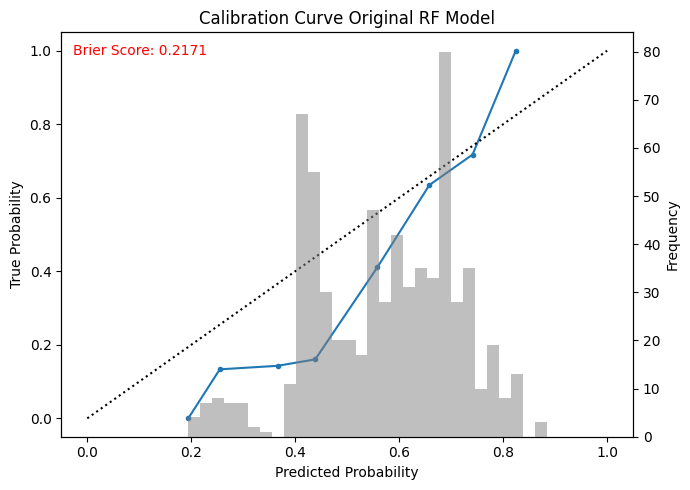

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

y_test_pred_prob = rf_model.predict_proba(X_test_preprocessed)[:, 1]
true_prob, pred_prob = calibration_curve(y_test, y_test_pred_prob, n_bins=10)

# Calculate the Brier Score
brier_score = brier_score_loss(y_test, y_test_pred_prob)

plt.figure(figsize=(7, 5))
plt.plot(pred_prob, true_prob, marker='.')
plt.plot([0, 1], [0, 1], ':', c='k')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve Original RF Model')
plt.text(0.02, 0.97, f'Brier Score: {brier_score:.4f}', fontsize=10, color='red', transform=plt.gca().transAxes, va='top', ha='left')
plt.twinx()
plt.hist(y_test_pred_prob, bins=30, alpha=0.5, color='gray')
plt.ylabel('Frequency')
plt.gca().set_xlabel('Predicted Probability')
plt.tight_layout()
plt.savefig('MLHC_project/Evaluation/Random_Forest_Model_calibration_curve_with_Brier.png')
plt.show()

**Run Calibrated Model**

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

rf_model_cal = CalibratedClassifierCV(rf_model, method='isotonic')
rf_model_cal.fit(X_train_preprocessed, y_train)

CalibratedClassifierCV(estimator=RandomForestClassifier(max_depth=12,
                                                        n_estimators=200),
                       method='isotonic')

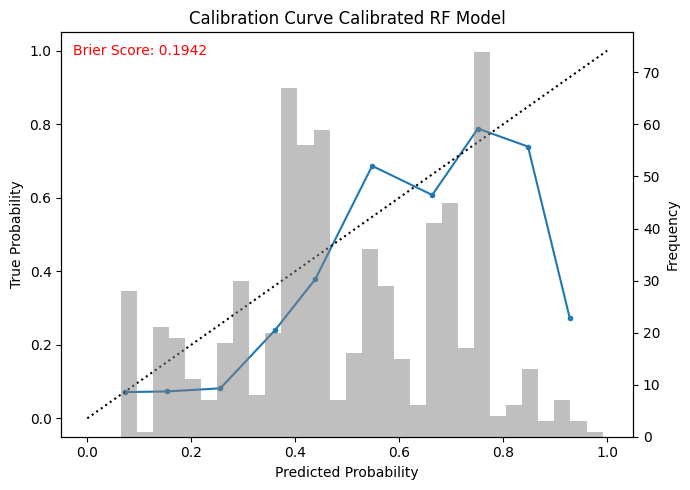

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

scores_cv = rf_model_cal.predict_proba(X_test_preprocessed)[:, 1]
true_prob, pred_prob = calibration_curve(y_test, scores_cv, n_bins=10)

# Calculate the Brier Score
brier_score = brier_score_loss(y_test, scores_cv)

plt.figure(figsize=(7, 5))
plt.plot(pred_prob, true_prob, marker='.')
plt.plot([0, 1], [0, 1], ':', c='k')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve Calibrated RF Model')
plt.text(0.02, 0.97, f'Brier Score: {brier_score:.4f}', fontsize=10, color='red', transform=plt.gca().transAxes, va='top', ha='left')
plt.twinx()
plt.hist(scores_cv, bins=30, alpha=0.5, color='gray')
plt.ylabel('Frequency')
plt.gca().set_xlabel('Predicted Probability')
plt.tight_layout()
plt.savefig('MLHC_project/Evaluation/Random_Forest_Model_calibration_curve_with_Brier_cal.png')
plt.show()

### Validate Best (calibrated) Model

In [ ]:
#@title Basic Metrics

from sklearn.metrics import accuracy_score, f1_score,precision_score, roc_auc_score, average_precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

y_test_pred = rf_model_cal.predict(X_test_preprocessed)
rf_accuracy = accuracy_score(y_test, y_test_pred)
rf_f1 = f1_score(y_test, y_test_pred)
rf_ppv = precision_score(y_test, y_test_pred)
rf_recall = recall_score(y_test, y_test_pred)
rf_auroc = roc_auc_score(y_test, rf_model_cal.predict_proba(X_test_preprocessed)[:, 1])
rf_aupr = average_precision_score(y_test, rf_model_cal.predict_proba(X_test_preprocessed)[:, 1])


print(f"The accuracy of the model is {rf_accuracy}")
print(f"The f1 score of the model is {rf_f1}")
print(f"The PPV of the model is {rf_ppv}")
print(f"The recall of the model is {rf_recall}")
print(f"The AUROC of the model is {rf_auroc}")
print(f"The AUPR of the model is {rf_aupr}")

The accuracy of the model is 0.7320359281437125
The f1 score of the model is 0.7089430894308942
The PPV of the model is 0.6942675159235668
The recall of the model is 0.7242524916943521
The AUROC of the model is 0.7869001602288467
The AUPR of the model is 0.6953337861172769


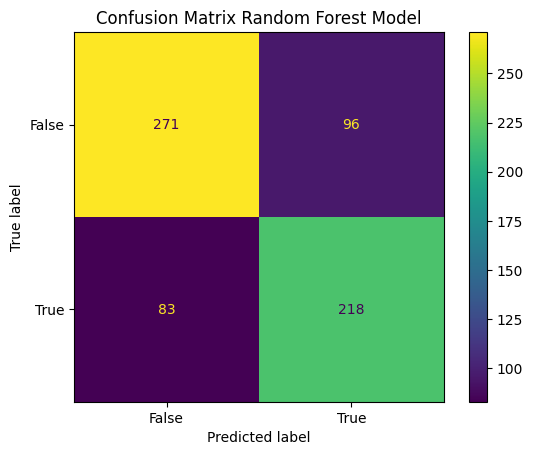

In [ ]:
#@title Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])
cm_display.plot()
plt.title("Confusion Matrix Random Forest Model")
plt.savefig('MLHC_project/Evaluation/Random_Forest_Model_confusion_matrix.png')

In [ ]:
#@title ROC curve
subsamples = []
num_subsamples = 20
subsample_proportion = 0.2
test_groups = np.array(data.loc[X_test_preprocessed.index.tolist()]['patient_code'])

gss = GroupShuffleSplit(n_splits=num_subsamples, test_size=subsample_proportion)

# Split into subsamples based on groups
for train_index, test_index in gss.split(X_test_preprocessed, groups=test_groups):
    subsample = [X_test_preprocessed.iloc[test_index], y_test.iloc[test_index]]
    subsamples.append(subsample)

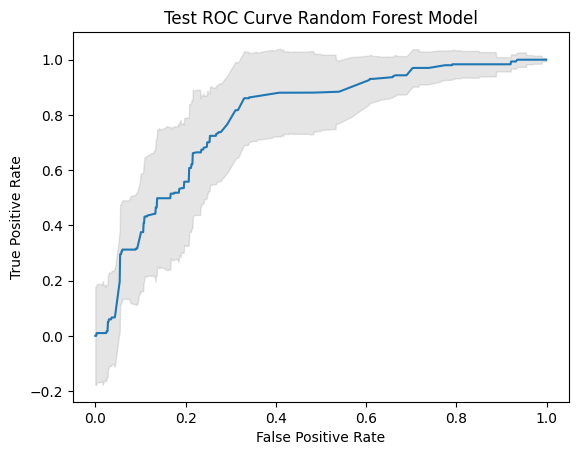

In [ ]:
#ROC curve
from sklearn.metrics import roc_curve
subsample_tprs = []
subsample_fprs = []
new_fpr = np.arange(0, 1, 0.001).tolist()
for (X_subsample, y_subsample) in subsamples:
    y_subsample_prob = rf_model_cal.predict_proba(X_subsample)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_subsample, y_subsample_prob)
    tpr_interp = np.interp(new_fpr, fpr, tpr)
    subsample_tprs.append(tpr_interp)

std_tprs = np.std(np.array(subsample_tprs), axis=0)

import matplotlib.pyplot as plt
y_test_pred_prob = rf_model_cal.predict_proba(X_test_preprocessed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
tpr_interp = np.interp(new_fpr, fpr, tpr)
plt.plot(new_fpr, tpr_interp)
plt.fill_between(new_fpr, tpr_interp - std_tprs, tpr_interp + std_tprs, color='grey', alpha=0.2)
plt.title('Test ROC Curve Random Forest Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('MLHC_project/Evaluation/Random_Forest_Model_roc_curve.png')

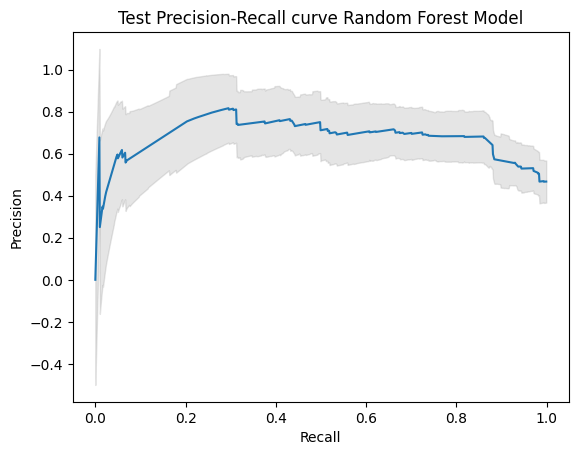

In [ ]:
#@title PR curve
from sklearn.metrics import precision_recall_curve

subsample_precision = []
new_recall = np.arange(0, 1, 0.001).tolist()
for (X_subsample, y_subsample) in subsamples:
    y_subsample_prob = rf_model_cal.predict_proba(X_subsample)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_subsample, y_subsample_prob)
    precision_interp = np.interp(new_recall, recall[::-1], precision[::-1])
    subsample_precision.append(precision_interp)

std_precision = np.std(np.array(subsample_precision), axis=0)

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
precision_interp = np.interp(new_recall, recall[::-1], precision[::-1])

plt.plot(new_recall, precision_interp)
plt.fill_between(new_recall, precision_interp - std_precision, precision_interp + std_precision, color='grey', alpha=0.2)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve Random Forest Model")
plt.savefig('MLHC_project/Evaluation/Random_Forest_Model_pr_curve.png')

### Feature Importance

In [ ]:
importances  = rf_model.feature_importances_
feature_scores = pd.Series(rf_model.feature_importances_, index=X_train_preprocessed.columns).sort_values(ascending=False)

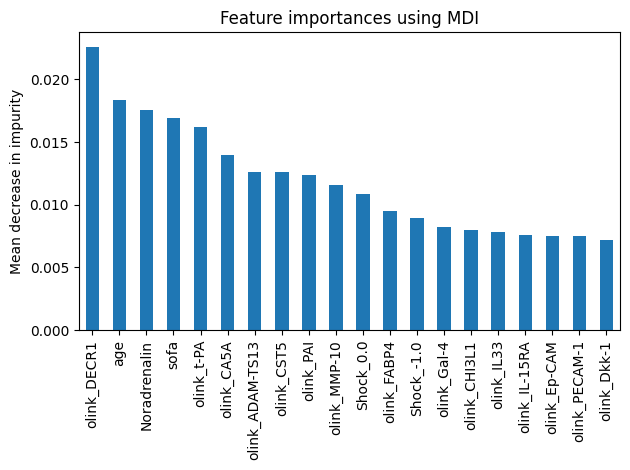

In [ ]:
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

fig, ax = plt.subplots()
# feature_scores[:20].plot.bar(yerr=std, ax=ax)
feature_scores[:20].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig("MLHC_project/Evaluation/RF_Feature_importances.png")

### SHAP

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.8 MB/s eta 0:00:00


In [ ]:
import shap
explainer = shap.Explainer(rf_model.predict, X_test_preprocessed)
shap_values = explainer(X_test_preprocessed, max_evals=(2*X_test_preprocessed.shape[1]) + 1)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Permutation explainer: 669it [35:41,  3.22s/it]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


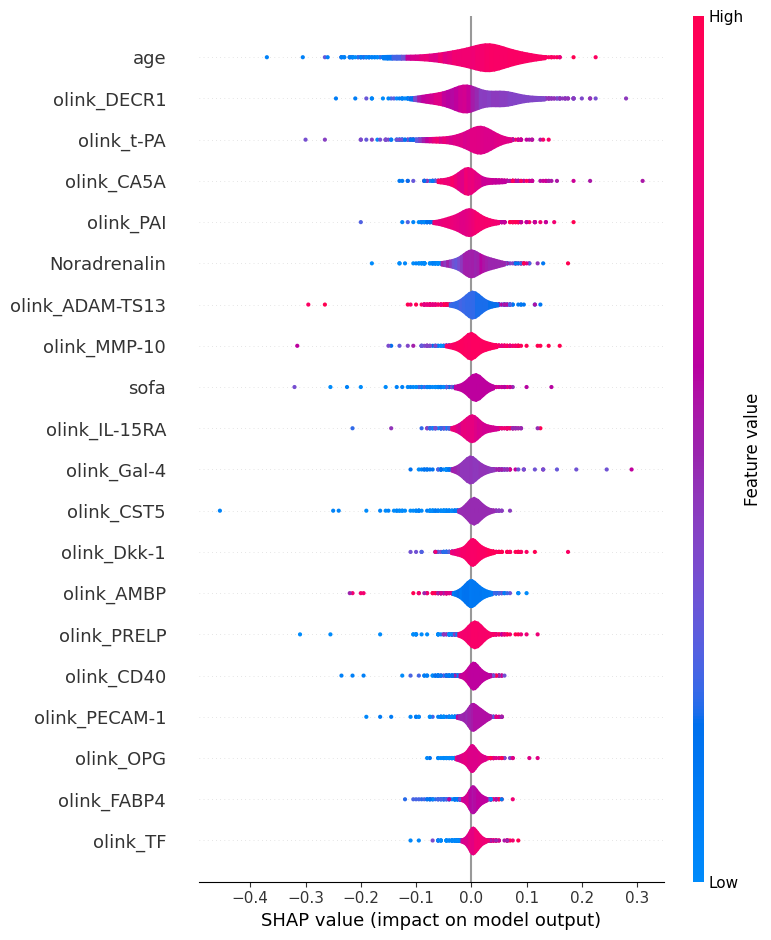

In [ ]:
# #@title Produce Plot
shap.summary_plot(shap_values, plot_type='violin',show=False)
# plt.savefig("MLHC_project/Evaluation/shap_summary_rf_2.png",dpi=700)
plt.show()

In [ ]:
#@title Extract Features Importance by SHAP
feature_names = X_test_preprocessed.columns
rf_resultX = pd.DataFrame(shap_values.values,columns=feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_important_features = shap_importance['col_name'][:20].to_list()
shap_important_features

['age',
 'olink_DECR1',
 'olink_t-PA',
 'olink_CA5A',
 'olink_PAI',
 'Noradrenalin',
 'olink_ADAM-TS13',
 'olink_MMP-10',
 'sofa',
 'olink_IL-15RA',
 'olink_Gal-4',
 'olink_CST5',
 'olink_Dkk-1',
 'olink_AMBP',
 'olink_PRELP',
 'olink_CD40',
 'olink_PECAM-1',
 'olink_OPG',
 'olink_FABP4',
 'olink_TF']

##Logistic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

###CV on hyperparamaters

In [ ]:
penalty = ['l1','l2']
C = [0.25,0.5,1]

params = {'model__penalty': penalty, 'model__C': C}
scoring = 'roc_auc'
num_cv_splits = 5
# train_groups = groups[X_train.index]

CV_model = run_CV(X_train, y_train, train_groups, LogisticRegression(solver='saga', max_iter=1000), params, scoring, num_cv_splits, preprocessor)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


The max_iter was reached which means the coef_ did not converge


[CV 1/5] END ..model__C=0.25, model__penalty=l1;, score=0.758 total time=   9.8s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END ..model__C=0.25, model__penalty=l1;, score=0.574 total time=  11.2s


The max_iter was reached which means the coef_ did not converge


[CV 3/5] END ..model__C=0.25, model__penalty=l1;, score=0.855 total time=  11.3s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END ..model__C=0.25, model__penalty=l1;, score=0.627 total time=  11.3s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END ..model__C=0.25, model__penalty=l1;, score=0.773 total time=  11.3s
[CV 1/5] END ..model__C=0.25, model__penalty=l2;, score=0.719 total time=   3.8s
[CV 2/5] END ..model__C=0.25, model__penalty=l2;, score=0.581 total time=   3.8s
[CV 3/5] END ..model__C=0.25, model__penalty=l2;, score=0.834 total time=   4.9s
[CV 4/5] END ..model__C=0.25, model__penalty=l2;, score=0.623 total time=   3.8s
[CV 5/5] END ..model__C=0.25, model__penalty=l2;, score=0.779 total time=   3.7s


The max_iter was reached which means the coef_ did not converge


[CV 1/5] END ...model__C=0.5, model__penalty=l1;, score=0.740 total time=  11.2s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END ...model__C=0.5, model__penalty=l1;, score=0.531 total time=  11.5s


The max_iter was reached which means the coef_ did not converge


[CV 3/5] END ...model__C=0.5, model__penalty=l1;, score=0.871 total time=  11.3s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END ...model__C=0.5, model__penalty=l1;, score=0.664 total time=   9.6s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END ...model__C=0.5, model__penalty=l1;, score=0.779 total time=  11.2s
[CV 1/5] END ...model__C=0.5, model__penalty=l2;, score=0.710 total time=   6.3s
[CV 2/5] END ...model__C=0.5, model__penalty=l2;, score=0.570 total time=   4.6s
[CV 3/5] END ...model__C=0.5, model__penalty=l2;, score=0.834 total time=   4.4s
[CV 4/5] END ...model__C=0.5, model__penalty=l2;, score=0.615 total time=   5.7s
[CV 5/5] END ...model__C=0.5, model__penalty=l2;, score=0.777 total time=   4.6s


The max_iter was reached which means the coef_ did not converge


[CV 1/5] END .....model__C=1, model__penalty=l1;, score=0.746 total time=  11.3s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END .....model__C=1, model__penalty=l1;, score=0.530 total time=  11.5s


The max_iter was reached which means the coef_ did not converge


[CV 3/5] END .....model__C=1, model__penalty=l1;, score=0.873 total time=  11.0s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END .....model__C=1, model__penalty=l1;, score=0.666 total time=   9.9s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END .....model__C=1, model__penalty=l1;, score=0.803 total time=  11.5s
[CV 1/5] END .....model__C=1, model__penalty=l2;, score=0.703 total time=   7.0s
[CV 2/5] END .....model__C=1, model__penalty=l2;, score=0.566 total time=   5.4s
[CV 3/5] END .....model__C=1, model__penalty=l2;, score=0.834 total time=   6.3s
[CV 4/5] END .....model__C=1, model__penalty=l2;, score=0.611 total time=   5.6s
[CV 5/5] END .....model__C=1, model__penalty=l2;, score=0.775 total time=   6.3s


The max_iter was reached which means the coef_ did not converge


In [ ]:
best_lr_model_params = CV_model.best_estimator_.get_params()

###Train best model

**Run Model**

In [ ]:
lr_model = LogisticRegression(C=best_lr_model_params['model__C'], penalty=best_lr_model_params['model__penalty'], solver='saga', max_iter=1000)
lr_model.fit(X_train_preprocessed, y_train)

The max_iter was reached which means the coef_ did not converge


LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

### Calibration

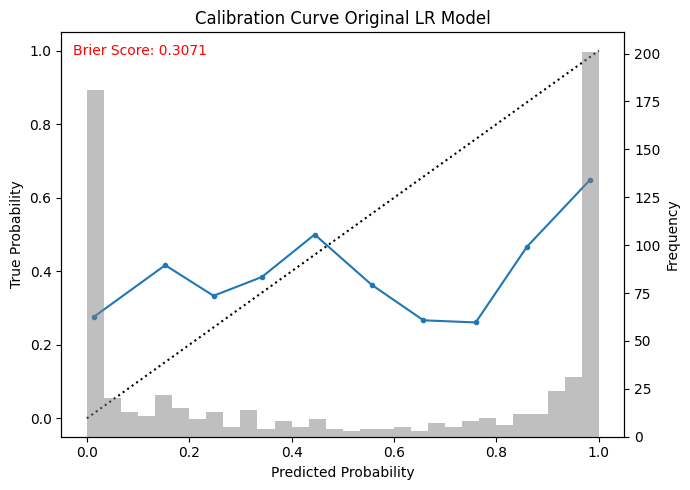

In [ ]:
y_test_pred_prob = lr_model.predict_proba(X_test_preprocessed)[:, 1]
true_prob, pred_prob = calibration_curve(y_test, y_test_pred_prob, n_bins=10)

# Calculate the Brier Score
brier_score = brier_score_loss(y_test, y_test_pred_prob)

plt.figure(figsize=(7, 5))
plt.plot(pred_prob, true_prob, marker='.')
plt.plot([0, 1], [0, 1], ':', c='k')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve Original LR Model')
plt.text(0.02, 0.97, f'Brier Score: {brier_score:.4f}', fontsize=10, color='red', transform=plt.gca().transAxes, va='top', ha='left')
plt.twinx()
plt.hist(y_test_pred_prob, bins=30, alpha=0.5, color='gray')
plt.ylabel('Frequency')
plt.gca().set_xlabel('Predicted Probability')
plt.tight_layout()
plt.savefig('MLHC_project/Evaluation/Logistic_Regression_Model_calibration_curve_with_Brier.png')
plt.show()

**Run Calibrated Model**

In [ ]:
lr_model_cal = CalibratedClassifierCV(lr_model, method='isotonic')
lr_model_cal.fit(X_train_preprocessed, y_train)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


CalibratedClassifierCV(estimator=LogisticRegression(C=1, max_iter=1000,
                                                    penalty='l1',
                                                    solver='saga'),
                       method='isotonic')

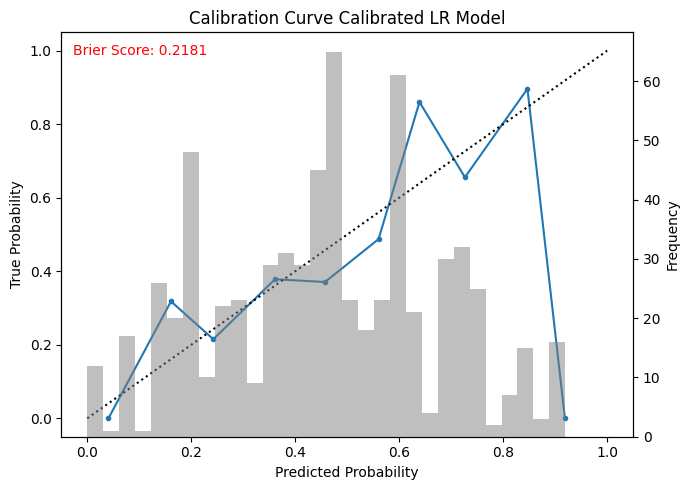

In [ ]:
scores_cv = lr_model_cal.predict_proba(X_test_preprocessed)[:, 1]
true_prob, pred_prob = calibration_curve(y_test, scores_cv, n_bins=10)

# Calculate the Brier Score
brier_score = brier_score_loss(y_test, scores_cv)

plt.figure(figsize=(7, 5))
plt.plot(pred_prob, true_prob, marker='.')
plt.plot([0, 1], [0, 1], ':', c='k')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve Calibrated LR Model')
plt.text(0.02, 0.97, f'Brier Score: {brier_score:.4f}', fontsize=10, color='red', transform=plt.gca().transAxes, va='top', ha='left')
plt.twinx()
plt.hist(scores_cv, bins=30, alpha=0.5, color='gray')
plt.ylabel('Frequency')
plt.gca().set_xlabel('Predicted Probability')
plt.tight_layout()
plt.savefig('MLHC_project/Evaluation/Logistic_Regression_Model_calibration_curve_with_Brier_cal.png')
plt.show()

###Validate best (calibrated) model

In [ ]:
#@title Basic Metrics
y_test_pred = lr_model_cal.predict(X_test_preprocessed)
lr_accuracy = accuracy_score(y_test, y_test_pred)
lr_f1 = f1_score(y_test, y_test_pred)
lr_ppv = precision_score(y_test, y_test_pred)
lr_recall = recall_score(y_test, y_test_pred)
lr_auroc = roc_auc_score(y_test, lr_model_cal.predict_proba(X_test_preprocessed)[:, 1])
lr_aupr = average_precision_score(y_test, lr_model_cal.predict_proba(X_test_preprocessed)[:, 1])


print(f"The accuracy of the model is {lr_accuracy}")
print(f"The f1 score of the model is {lr_f1}")
print(f"The PPV of the model is {lr_ppv}")
print(f"The recall of the model is {lr_recall}")
print(f"The AUROC of the model is {lr_auroc}")
print(f"The AUPR of the model is {lr_aupr}")

The accuracy of the model is 0.6841317365269461
The f1 score of the model is 0.6291739894551844
The PPV of the model is 0.667910447761194
The recall of the model is 0.5946843853820598
The AUROC of the model is 0.7133895190418857
The AUPR of the model is 0.6195090277047136


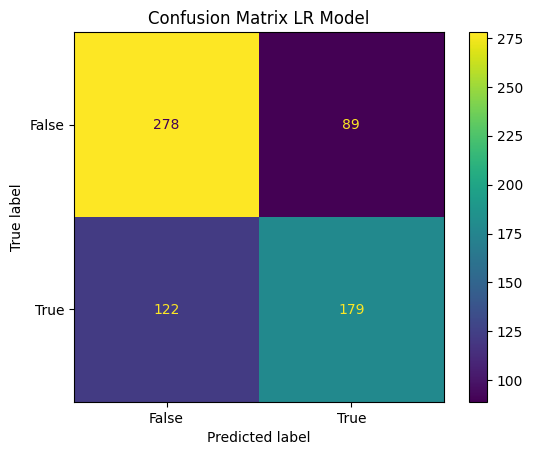

In [ ]:
#@title Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])
cm_display.plot()
plt.title("Confusion Matrix LR Model")
plt.savefig('MLHC_project/Evaluation/LR_Model_confusion_matrix.png')

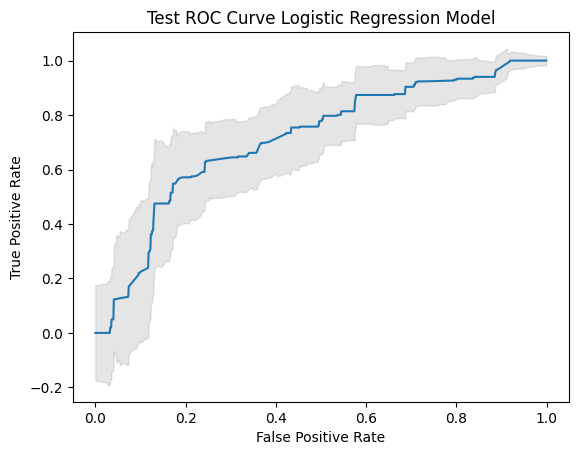

In [ ]:
#@title ROC curve

subsamples = []
num_subsamples = 20
subsample_proportion = 0.2
X_test_preprocessed = pd.DataFrame(X_test_preprocessed)
test_groups = np.array(data.loc[X_test_preprocessed.index.tolist()]['patient_code'])

gss = GroupShuffleSplit(n_splits=num_subsamples, test_size=subsample_proportion)

# Split into subsamples based on groups
for train_index, test_index in gss.split(X_test_preprocessed, groups=test_groups):
    subsample = [X_test_preprocessed.iloc[test_index], y_test.iloc[test_index]]
    subsamples.append(subsample)


from sklearn.metrics import roc_curve
subsample_tprs = []
subsample_fprs = []
new_fpr = np.arange(0, 1, 0.001).tolist()
for (X_subsample, y_subsample) in subsamples:
    y_subsample_prob = lr_model_cal.predict_proba(X_subsample)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_subsample, y_subsample_prob)
    tpr_interp = np.interp(new_fpr, fpr, tpr)
    subsample_tprs.append(tpr_interp)

std_tprs = np.std(np.array(subsample_tprs), axis=0)

import matplotlib.pyplot as plt
y_test_pred_prob = lr_model_cal.predict_proba(X_test_preprocessed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
tpr_interp = np.interp(new_fpr, fpr, tpr)
plt.plot(new_fpr, tpr_interp)
plt.fill_between(new_fpr, tpr_interp - std_tprs, tpr_interp + std_tprs, color='grey', alpha=0.2)
plt.title('Test ROC Curve Logistic Regression Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('MLHC_project/Evaluation/LR_Model_roc_curve.png')

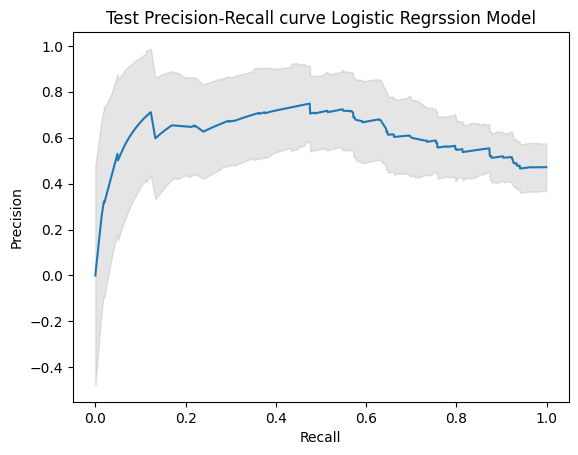

In [ ]:
#@title PR curve
from sklearn.metrics import precision_recall_curve

subsample_precision = []
new_recall = np.arange(0, 1, 0.001).tolist()
for (X_subsample, y_subsample) in subsamples:
    y_subsample_prob = lr_model_cal.predict_proba(X_subsample)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_subsample, y_subsample_prob)
    precision_interp = np.interp(new_recall, recall[::-1], precision[::-1])
    subsample_precision.append(precision_interp)

std_precision = np.std(np.array(subsample_precision), axis=0)

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
precision_interp = np.interp(new_recall, recall[::-1], precision[::-1])

plt.plot(new_recall, precision_interp)
plt.fill_between(new_recall, precision_interp - std_precision, precision_interp + std_precision, color='grey', alpha=0.2)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve Logistic Regrssion Model")
plt.savefig('MLHC_project/Evaluation/LR_Model_pr_curve.png')

## Combined validations

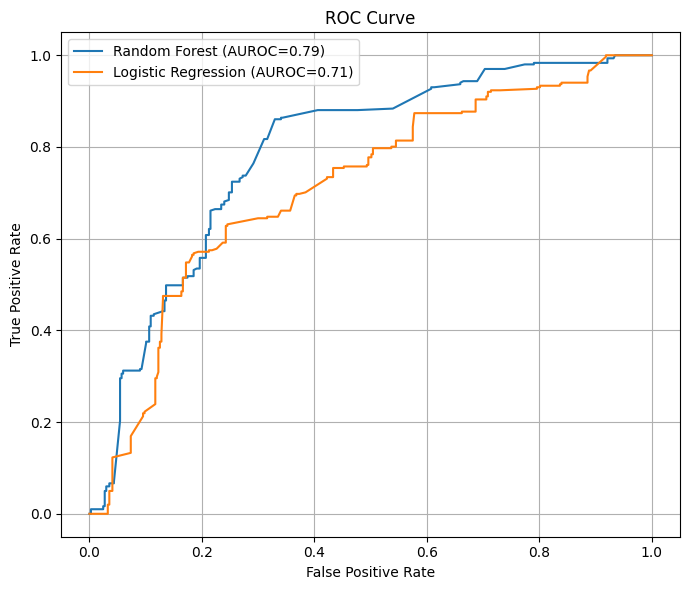

In [ ]:
#ROC
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

# ROC curve for Random Forest model
y_test_pred_prob_rf = rf_model_cal.predict_proba(X_test_preprocessed)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_test_pred_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUROC={rf_auroc:.2f})')

# ROC curve for Logistic Regression model
y_test_pred_prob_lr = lr_model_cal.predict_proba(X_test_preprocessed)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_test_pred_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUROC={lr_auroc:.2f})')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('MLHC_project/Evaluation/both_models_roc_curve.png')
plt.show()

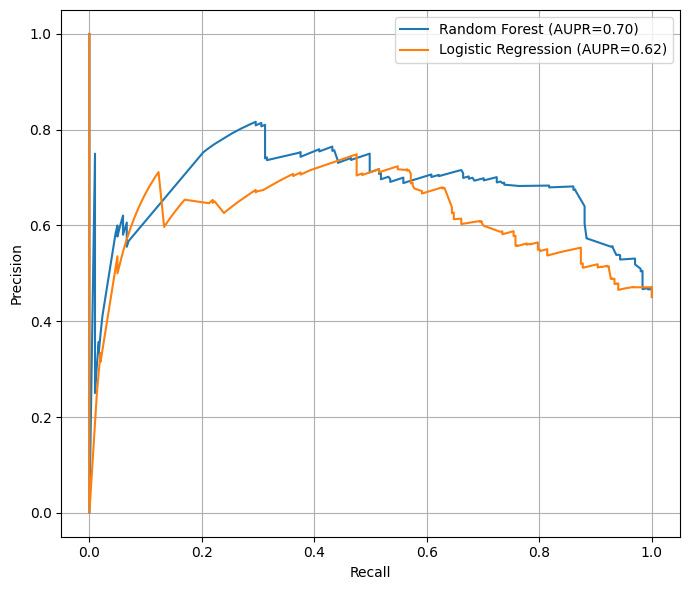

In [ ]:
#PR
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(7, 6))

y_test_pred_prob_rf = rf_model_cal.predict_proba(X_test_preprocessed)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob_rf)
plt.plot(recall, precision, label=f'Random Forest (AUPR={rf_aupr:.2f})')

y_test_pred_prob_lr = lr_model_cal.predict_proba(X_test_preprocessed)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob_lr)
plt.plot(recall, precision, label=f'Logistic Regression (AUPR={lr_aupr:.2f})')

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('MLHC_project/Evaluation/both_models_pr_curve.png')
plt.show()

## Feature Importance

In [ ]:
# adjust features LR model
top_features_lr_idx = np.argsort(-lr_model.coef_).tolist()[0][:20]
top_features_lr = X_test_preprocessed.iloc[:,top_features_lr_idx].columns.tolist()
for f in top_features_lr :
  if "_" in f:
    try:
        number = float(f.split("_")[1])
        top_features_lr.remove(f)
        top_features_lr.append(f.split("_")[0])
    except ValueError:
      continue

In [ ]:
print(top_features_lr)

['age', 'olink_MMP-10', 'sofa', 'olink_PECAM-1', 'olink_IL16', 'olink_IL-4RA', 'olink_TIE2', 'olink_MCP-2', 'olink_TNFRSF10C', 'olink_PAI', 'olink_SERPINA12', 'olink_TF', 'olink_IGFBP-1', 'olink_CHI3L1', 'olink_CXCL6', 'Center', 'Intakeofceftazidimeavibactam', 'tia', 'ShockClassification', 'Intakeofcolistin']


In [ ]:
# adjust features RF model
top_features_rf = feature_scores.index.to_list()[:20]
for f in top_features_rf :
  if "_" in f:
    try:
        number = float(f.split("_")[1])
        top_features_rf.remove(f)
        top_features_rf.append(f.split("_")[0])
    except ValueError:
      continue

## Compare best features models

### Check for olink parameters in groups

In [ ]:
correlated_groups_olink = corr_feature_selector.get_correlated_groups()
sig_groups= {}
for feature in top_features_rf:
  for group in correlated_groups_olink:
    if feature in group:
      sig_groups[feature] = group
for feature in top_features_lr:
  for group in correlated_groups_olink:
    if feature in group:
      sig_groups[feature] = group

print(f"number of correlated groups significant: {len(sig_groups)}")

number of correlated groups significant: 0


In [ ]:
#@title common features between rf and shapley and between rf and lr
common_features_rf_lr = set(top_features_lr).intersection(top_features_rf)
common_features_rf_shap_model = (set(shap_important_features).intersection(top_features_rf))
diff_rf_shap = set(shap_important_features).difference(top_features_rf)
diff_rf_shap_1 = set(top_features_rf).difference(shap_important_features)
print(f"LR and RF models have {len(common_features_rf_lr)} common significant features")
print(f"RF object and Shapley have {len(common_features_rf_shap_model)} common significant features")
print(f"The different features between Shapley and RF significant features are {diff_rf_shap}")
print(f"The different features between Shapley and RF significant features are {diff_rf_shap_1}")

LR and RF models have 6 common significant features
RF object and Shapley have 15 common significant features
The different features between Shapley and RF significant features are {'olink_PRELP', 'olink_TF', 'olink_AMBP', 'olink_CD40', 'olink_OPG'}
The different features between Shapley and RF significant features are {'olink_Ep-CAM', 'olink_IL33', 'olink_CHI3L1', 'Shock'}


# SAVE MODEL OBJECTS

In [ ]:
import pickle
def save_obj(name,obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#DATA
save_obj("MLHC_project/SAVED RUN/X_train_preprocessed",X_train_preprocessed)
save_obj("MLHC_project/SAVED RUN/y_train",y_train)
save_obj("MLHC_project/SAVED RUN/X_test_preprocessed",X_test_preprocessed)
save_obj("MLHC_project/SAVED RUN/y_test",y_test)

#MODEL
save_obj("MLHC_project/SAVED RUN/rf_model",rf_model)
# save_obj("MLHC_project/SAVED RUN/rf_model_calibrated",rf_model_cal)
# save_obj("MLHC_project/SAVED RUN/lr_model",lr_model)
# save_obj("MLHC_project/SAVED RUN/lr_model_cal",lr_model_cal)
save_obj("MLHC_project/SAVED RUN/shap_values",shap_values)
save_obj("MLHC_project/SAVED RUN/shap_important_features",shap_important_features)

In [ ]:
#@ Load Objects
def load_obj(path):
  with open(path, 'rb') as f:
    return pickle.load(f)

rf_model_calibrated = load_obj("MLHC_project/SAVED RUN/rf_model_calibrated.pkl")
rf_model= load_obj("MLHC_project/SAVED RUN/rf_model.pkl")
shap_important_features = load_obj("MLHC_project/SAVED RUN/shap_important_features.pkl")
clinical_sig = load_obj("MLHC_project/SAVED RUN/clinical_sig_cox.pkl")
olink_sig = load_obj("MLHC_project/SAVED RUN//olink_sig_cox.pkl")

# Feature Selection

### Measurements - by Survival Cox Hazard Ratio Model (for classification model)

In [ ]:
pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 6.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=260d21dea607f46608644753cb75c9a3d057efb4e7cd47e6694bbca92a8467aa
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from lifelines import CoxPHFitter

data_for_cph_olink = X_train.filter(like='olink')
data_for_cph_olink = data_for_cph_olink.merge(data[['survival28','outcome28']],left_index=True,right_index=True,how='inner').replace({'Yes':1,'No':0})
not_olink = [c for c in numeric_features if 'olink' not in c]
data_for_cph_clinical = X_train[not_olink]
data_for_cph_clinical = data_for_cph_clinical.merge(data[['survival28','outcome28']],left_index=True,right_index=True,how='inner').replace({'Yes':1,'No':0})

In [ ]:
def cph_hr_plot(data_for_cph,features_type,penalize=0):
  cph = CoxPHFitter(penalizer=penalize)
  cph.fit(data_for_cph.dropna(), duration_col='survival28', event_col='outcome28', show_progress=True)
  plt.subplots(figsize = (10, 6))
  cph.plot()
  plt.title(f"Ranking of the {features_type} features by their log(HR)")
  plt.savefig(f"MLHC_project/Feature Selection/{features_type}.png",bbox_inches="tight")
  return cph


def plot_significant_features(cph_model,data_for_cph):
  cph_summary = cph_model.summary
  significance_level = 0.05/cph_summary.shape[0]
  significant_features = cph_summary[cph_summary['p'] < significance_level].nlargest(10,'exp(coef)')
  for feature in significant_features.index:
    quantile_values = (data_for_cph[feature].quantile([.1,.25, .5,.75,.9])).drop_duplicates().to_list()
    cph_model.plot_partial_effects_on_outcome(covariates = feature, values = quantile_values, cmap = 'coolwarm')
    plt.title(f'{feature} Partial Effects on Outcome')
    plt.savefig(f"MLHC_project/Feature Selection/cox_survival_{feature}.png",bbox_inches="tight")
  return significant_features

Iteration 1: norm_delta = 1.13116, step_size = 0.9500, log_lik = -2431.28273, newton_decrement = 251.09926, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.53621, step_size = 0.9500, log_lik = -2193.34559, newton_decrement = 32.77871, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.27859, step_size = 0.9500, log_lik = -2158.13088, newton_decrement = 2.29331, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.16264, step_size = 1.0000, log_lik = -2155.41686, newton_decrement = 3.47019, seconds_since_start = 0.0
Iteration 5: norm_delta = 7.16510, step_size = 0.9800, log_lik = -2151.83272, newton_decrement = 3.34159, seconds_since_start = 0.0
Iteration 6: norm_delta = 6.63363, step_size = 0.2401, log_lik = -2150.40958, newton_decrement = 2.42814, seconds_since_start = 0.0
Iteration 7: norm_delta = 6.62059, step_size = 0.0765, log_lik = -2150.05207, newton_decrement = 2.25360, seconds_since_start = 0.0
Iteration 8: norm_delta = 6.64506, step_size = 0.0323, log_lik = -2149.90

Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


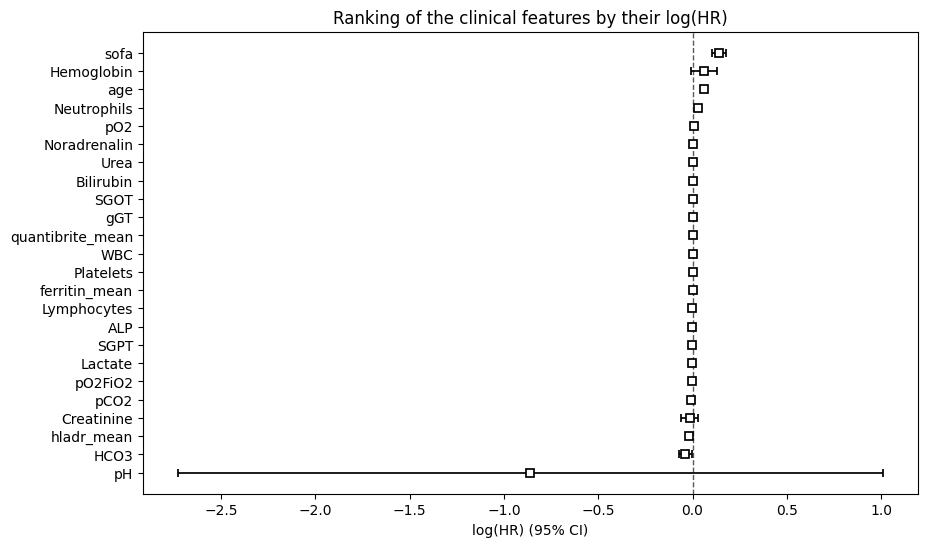

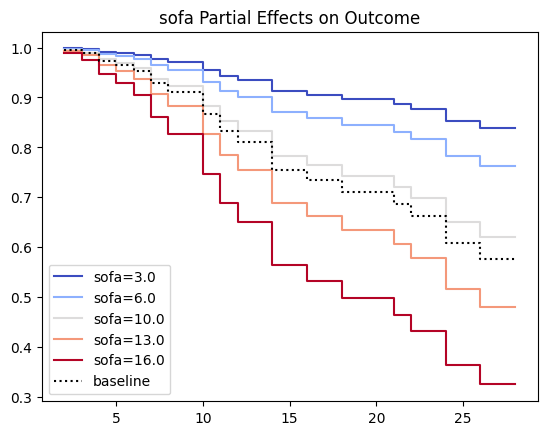

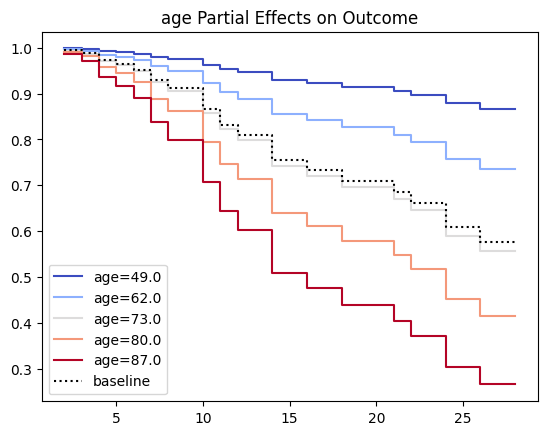

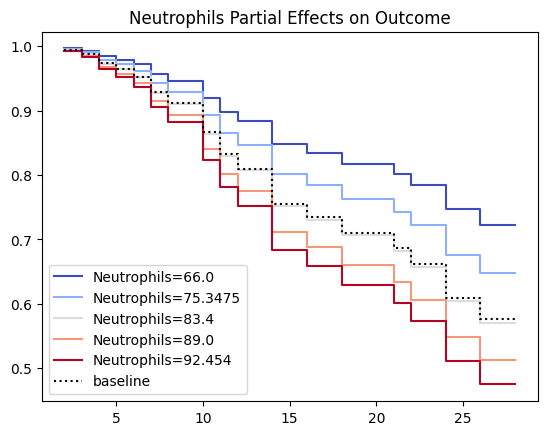

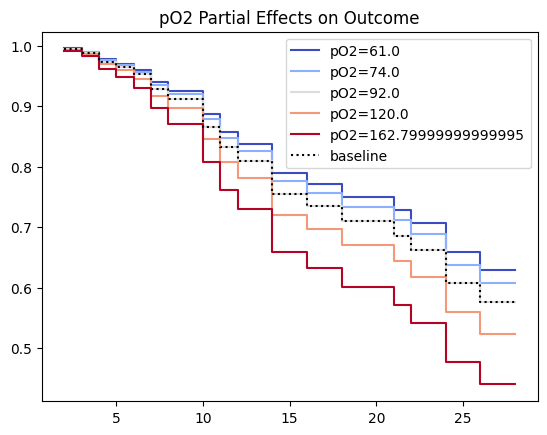

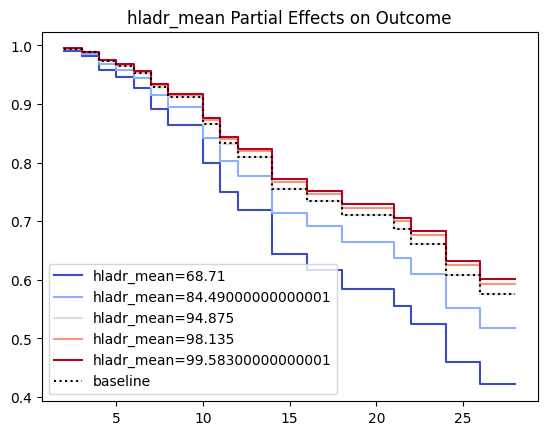

In [ ]:
cph_clinical = cph_hr_plot(data_for_cph_clinical,'clinical')
clinical_sig = plot_significant_features(cph_clinical,data_for_cph_clinical)

Iteration 1: norm_delta = 3.11821, step_size = 0.9500, log_lik = -3854.21198, newton_decrement = 982.11787, seconds_since_start = 0.5
Iteration 2: norm_delta = 1.71197, step_size = 0.9500, log_lik = -3222.03137, newton_decrement = 379.62897, seconds_since_start = 1.0
Iteration 3: norm_delta = 1.41723, step_size = 0.9500, log_lik = -3025.45674, newton_decrement = 130.77323, seconds_since_start = 1.6
Iteration 4: norm_delta = 3.64761, step_size = 1.0000, log_lik = -3174.47748, newton_decrement = 766.77303, seconds_since_start = 2.1
Iteration 5: norm_delta = 3.92319, step_size = 0.9800, log_lik = -3444.91878, newton_decrement = 635.25220, seconds_since_start = 2.7
Iteration 6: norm_delta = 5.18597, step_size = 0.9604, log_lik = -3294.85463, newton_decrement = 1162.18869, seconds_since_start = 3.2
Iteration 7: norm_delta = 0.96366, step_size = 0.2353, log_lik = -3003.23787, newton_decrement = 78.79101, seconds_since_start = 3.7
Iteration 8: norm_delta = 0.39033, step_size = 0.2998, log_lik

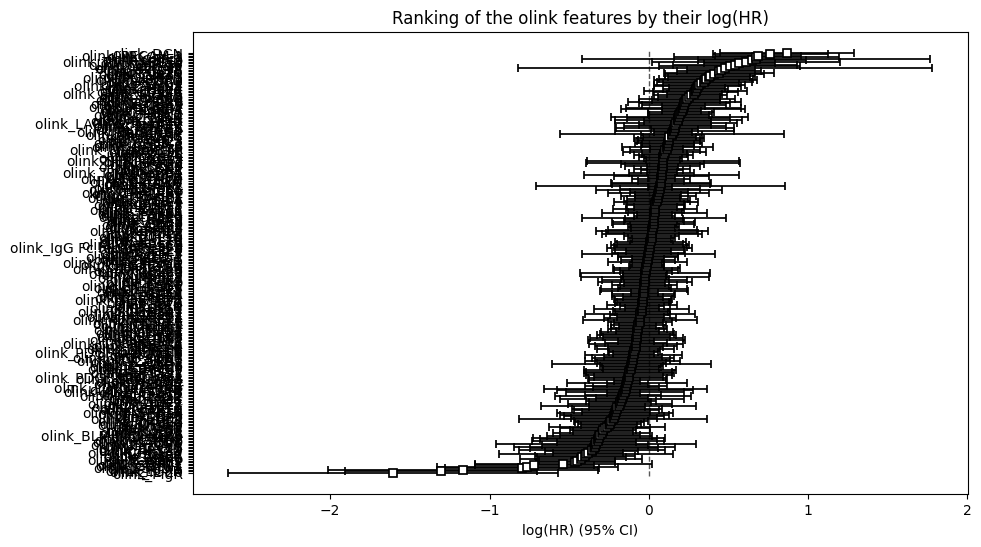

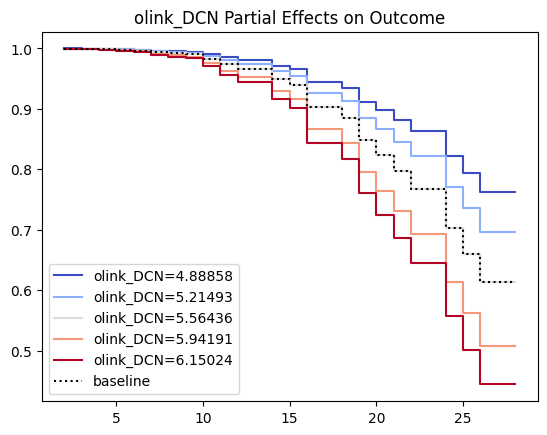

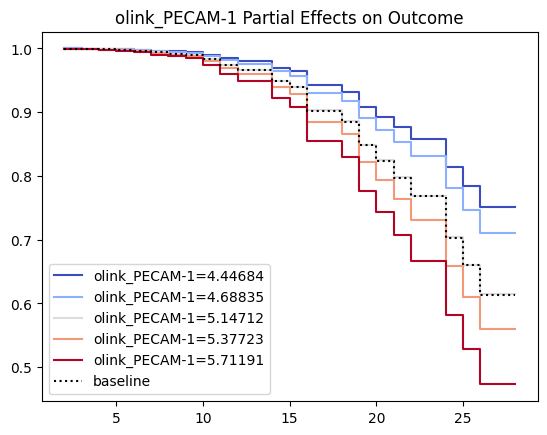

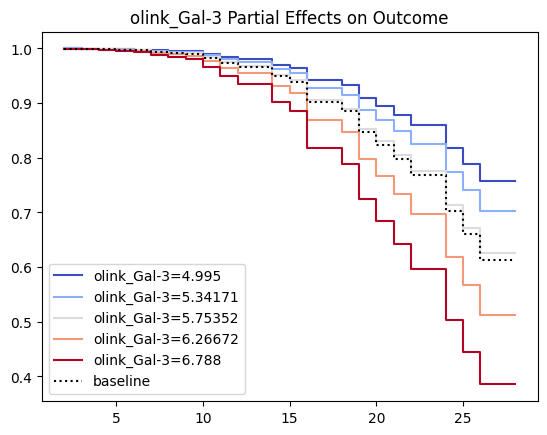

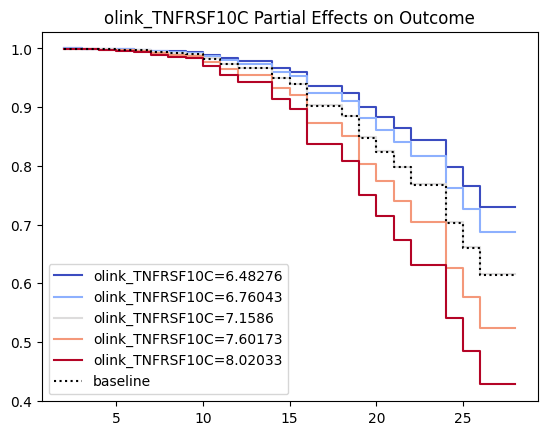

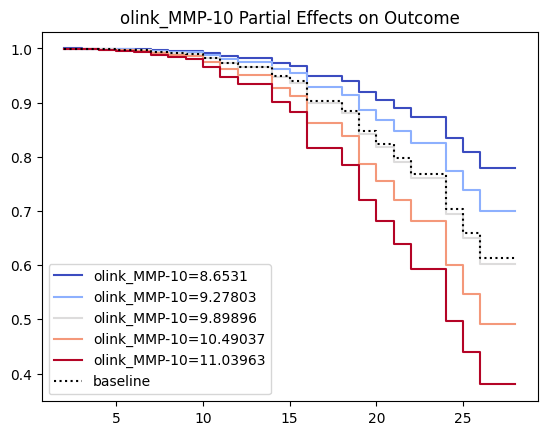

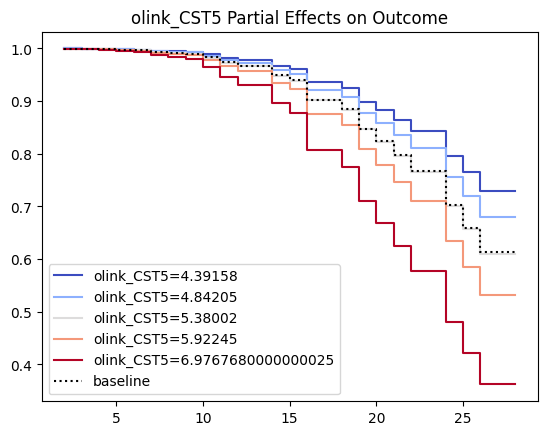

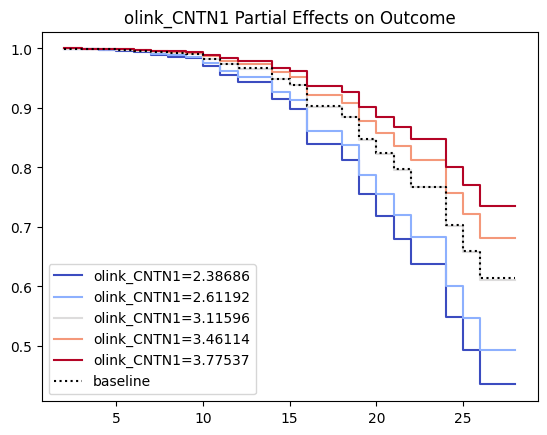

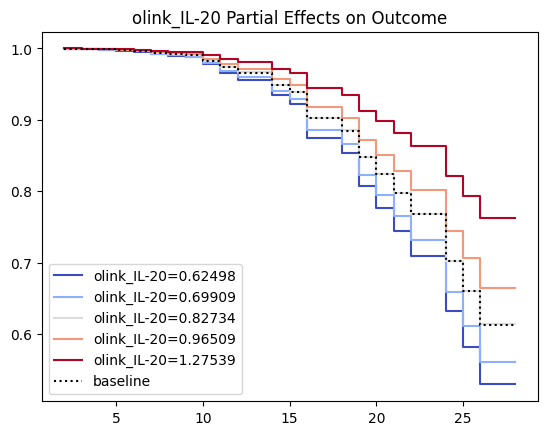

In [ ]:
cph_olink = cph_hr_plot(data_for_cph_olink,'olink',penalize=0.05)
olink_sig = plot_significant_features(cph_olink,data_for_cph_olink)

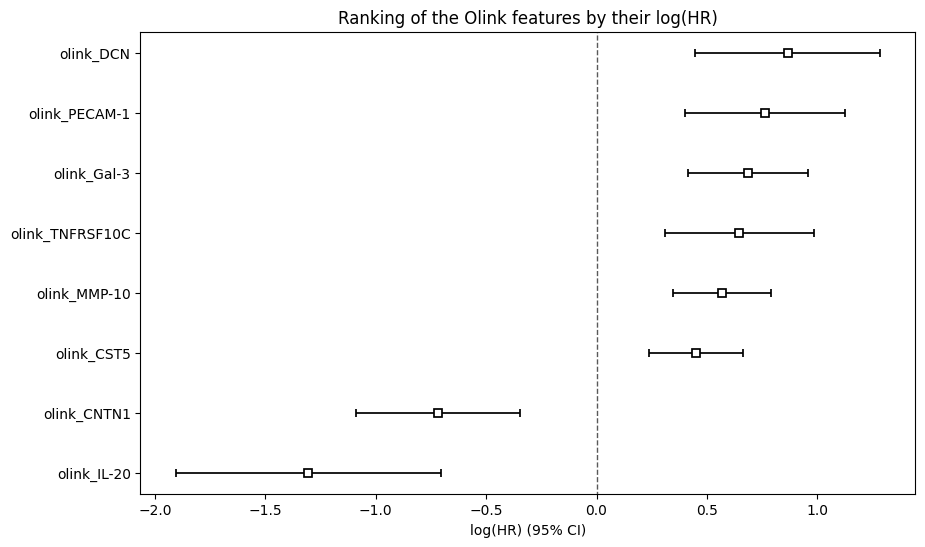

In [ ]:
plt.subplots(figsize = (10, 6))
cph_olink.plot(columns = olink_sig.index.to_list())
plt.title(f"Ranking of the Olink features by their log(HR)")
plt.savefig(f"MLHC_project/Feature Selection/olink.png",bbox_inches="tight")

In [ ]:
save_obj("MLHC_project/clinical_sig_cox",clinical_sig)
save_obj("MLHC_project/olink_sig_cox",olink_sig)

# Endotype Classification Model

In [ ]:
#@title Prepare Data to Classify
features_for_endotypes = list(set(clinical_sig.index.to_list() + olink_sig.index.to_list() + shap_important_features))

X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X[numeric_features]), columns=numeric_features)
X_numeric_imputed = X_numeric_imputed[X_numeric_imputed.columns.intersection(features_for_endotypes)]

X_endo_normalized = scaler.fit_transform(X_numeric_imputed)

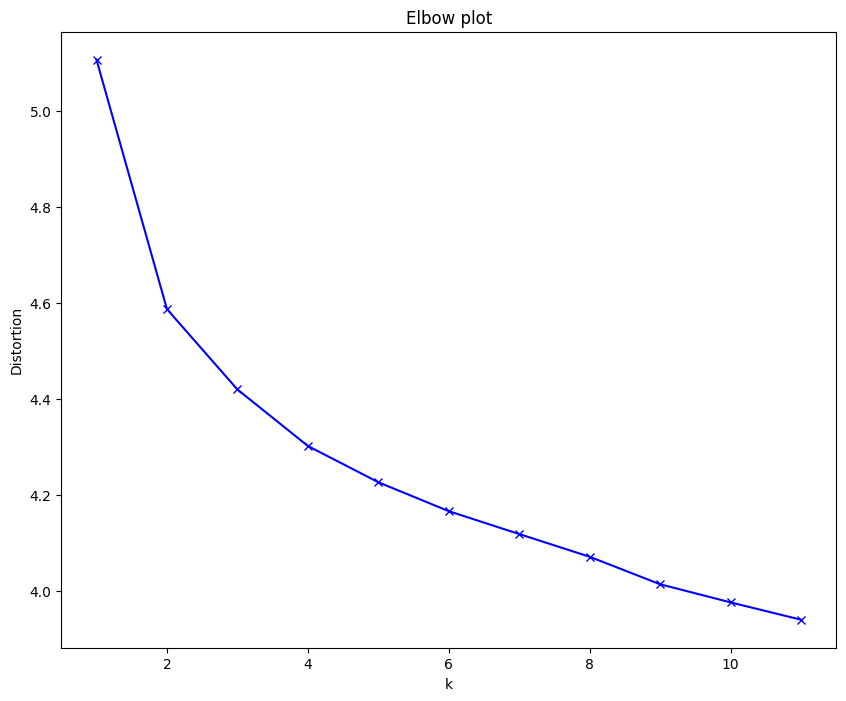

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title Elbow plot

from scipy.spatial.distance import cdist
def elbow_plot_for_kmeans(df,savefig):
    """
    plot the elbow plot for the kmeans clustering
    """
    from sklearn.cluster import KMeans
    distortions = []
    K = range(1, 12)
    for k in K:
        kmeanModel = KMeans(n_clusters=k,n_init=10).fit(df)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
    plt.figure(figsize=(10, 8))
    plt.title('Elbow plot')
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.show()
    plt.savefig(savefig)

elbow_plot_for_kmeans(X_endo_normalized,"MLHC_project/Endotypes/by shapley features/Elbow_plot_0509.png")

In [ ]:
#@title Run K-means

def k_means_data(df, n):
    #Perform k-means clustering on the dataframe of the rows
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n, random_state=42).fit(df)
    return kmeans.labels_

n_chosen = 5
kmeans_clusters = pd.DataFrame(k_means_data(X_endo_normalized, n=n_chosen))
kmeans_clusters.columns=['cluster']
data_to_tsne = pd.concat([kmeans_clusters,pd.DataFrame(X_endo_normalized)],axis=1)
data_to_tsne.columns = ['cluster']+ X_numeric_imputed.columns.to_list()

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [ ]:
#@title T-SNE
from sklearn.manifold import TSNE

def plot_tsne_with_kmeans(df, saveplot, title):
    tsne = TSNE(n_components=2,random_state=42)
    tsne_res = tsne.fit_transform(df)
    tsne_res_with_clusters = np.concatenate((df[['cluster']].values, tsne_res), axis=1)
    tsne_res_with_clusters_df = pd.DataFrame(tsne_res_with_clusters)

    plt.figure(figsize=(10, 8))
    plt.title(title)
    for label in tsne_res_with_clusters_df[0].unique():
        # plot the group according to kmeans cluster
        plt.scatter(x=tsne_res_with_clusters_df.loc[tsne_res_with_clusters_df[0] == label, 1],
                    y=tsne_res_with_clusters_df.loc[tsne_res_with_clusters_df[0] == label, 2], s=5)

        # randomly sample
        tmp = tsne_res_with_clusters_df.loc[tsne_res_with_clusters_df[0] == label].sample(1)
        # add label to some random points per group
        for _, row in tmp.iterrows():
            plt.annotate(int(label), (row[1], row[2]), size=20, weight='bold')
    plt.savefig(saveplot)
    plt.show()
    return tsne_res_with_clusters_df

In [ ]:
tsne_obj = plot_tsne_with_kmeans(data_to_tsne,f"MLHC_project/Endotypes/by shapley features/Tsne_res_features_{n_chosen}_0709.png",f"T-SNE projection of kmeans(n={n_chosen}) results")

In [ ]:
tsne_obj_1 = pd.concat([tsne_obj,data_to_tsne],axis=1).set_index(orig_groups)
# tsne_obj.columns
# tsne_obj_1['cluster']
tsne_obj_1 = tsne_obj_1[tsne_obj_1['cluster'] == 0]
# tsne_obj_1[tsne_obj_1[2]>=40]

In [ ]:
# Check how many patients to clstr/clstr to patients
code_to_clstr = {}
clstr_to_code={}
# Iterate through the indices and columns
for code, clstr in zip(orig_groups, kmeans_clusters['cluster']):
    if code not in code_to_clstr:
        code_to_clstr[code] = set()
    code_to_clstr[code].add(clstr)
    if clstr not in clstr_to_code:
        clstr_to_code[clstr] = set()
    clstr_to_code[clstr].add(code)

# how many patients belong to two or more clusters:
total={sum:0 for sum in range(1,6)}
for code in code_to_clstr:
    total[len(code_to_clstr[code])] +=1

for val in total:
  print(f"{total[val]} patients appear in {val} clusters")


In [ ]:
# create df of endotypes for basic analysis
endo_to_analyze = pd.concat([pd.DataFrame(kmeans_clusters['cluster']).set_index(orig_groups),data.set_index('patient_code')],axis=1)
endo_to_analyze = endo_to_analyze[['outcome28','survival28','cluster']+olink_sig.index.to_list() + shap_important_features]

features_to_violin = endo_to_analyze[['cluster','age','survival28','outcome28','sofa']].reset_index()

In [ ]:
#@title Distribution of survival days outcome and sofa across clusters

import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['survival28','outcome28','sofa']:
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    sns.barplot(data=features_to_violin.drop_duplicates(subset='patient_code'), x='cluster', y=feature, capsize=.2, errcolor=".5")
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.title(f'Distribution of {feature} Across Clusters')
    plt.savefig(f"MLHC_project/Endotypes/by shapley features/barplot_{feature}_{n_chosen}_clusters_0509.png")
    plt.show()

In [ ]:
#@title Distribution of age across clusters differed by outcome28
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.violinplot(data=features_to_violin.drop_duplicates(subset='patient_code'), x='cluster', y='age',scale="count",hue='outcome28')
# sns.violinplot(data=features_to_violin.drop_duplicates(subset='patient_code'), x='cluster', y='age',scale="count")
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.title('Distribution of Age Across Clusters')
plt.legend(title='Deceased', loc='upper right',prop={'size':8}).get_title().set_fontsize('8')
plt.savefig(f"MLHC_project/Endotypes/by shapley features/violin_age_outcome_{n_chosen}_clusters_up.png")
plt.show()

In [ ]:
#@title Distribution of sofa across clusters differed by outcome28
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.violinplot(data=features_to_violin.drop_duplicates(subset='patient_code'), x='cluster', y='sofa',scale="count")
# sns.violinplot(data=features_to_violin.drop_duplicates(subset='patient_code'), x='cluster', y='sofa',scale="count",hue='outcome28')
plt.xlabel('Cluster')
plt.ylabel('Sofa')
plt.title('Distribution of sofa Across Clusters')
# plt.legend(title='Outcome', loc='lower right')
plt.savefig(f"MLHC_project/Endotypes/by shapley features/violin_sofa_outcome_{n_chosen}_clusters.png")
plt.show()

In [ ]:
#@title Heatmap of differences between olink important features
cols_to_hm = list(set(endo_to_analyze.filter(like='olink').columns.to_list() +['cluster']))
cluster_medians = endo_to_analyze[cols_to_hm].groupby('cluster').median()

In [ ]:
X_endo_normalized = pd.DataFrame(X_endo_normalized,columns=X_numeric_imputed.columns)
X_endo_normalized['cluster'] = endo_to_analyze['cluster'].values
cluster_medians = X_endo_normalized[cols_to_hm].groupby('cluster').median()
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_medians.T.drop_duplicates().T,cmap = 'coolwarm',linewidths=0.1,annot=True,annot_kws={"fontsize":5})
plt.title('Olink Significant Features Median Differences Across Clusters')
plt.savefig(f"MLHC_project/Endotypes/by shapley features/heatmap_olink_within_clusters_{n_chosen}_clusters_all_olink_normalized.png",bbox_inches="tight")
plt.show()